In [1]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree
import numpy as np
import os
import cv2

#### Data Source:
https://www.kaggle.com/andrewmvd/face-mask-detection

In [2]:
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    import xml.etree.ElementTree as etree
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    fname = z.find('./filename').text
    dicts = [{obj.find('name').text: [int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))]}
             for obj in objects]
    return {'size': size, 'filename': fname, 'objects': dicts}

def decode_objects(xml_file):
    input_data=extract_xml_annotation(xml_file)
    objects=input_data.get('objects')
    filename=input_data['filename']
    labels=[]
    box_cords=[]
    for d in objects:
        for key in d:
            labels.append(key)
            box_cords.append(d[key])
    return labels,box_cords,filename

In [3]:
import glob
xml_files = glob.glob('annotations/*.xml')

In [4]:
len(xml_files)

853

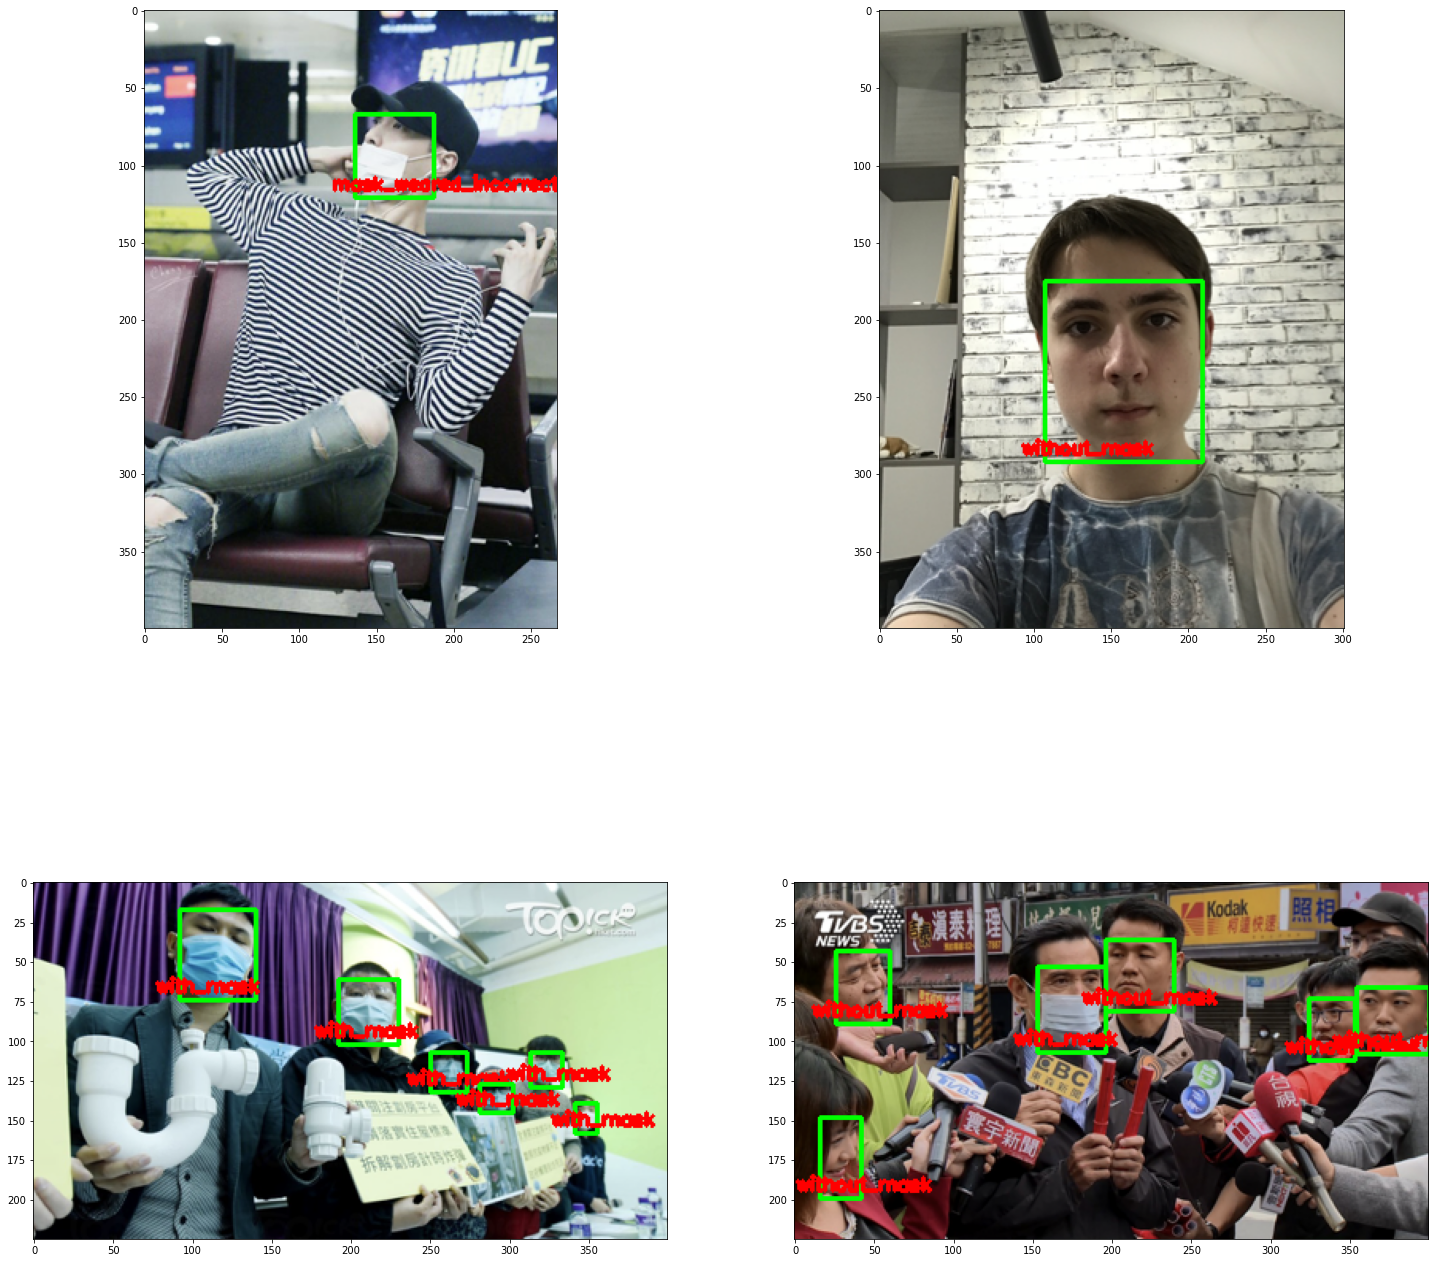

In [10]:
#print(xml_files[1000])
fig, ax = plt.subplots(2,2, figsize = (25,25))
for i in range(2):
    for j in range(2):
        random_img=np.random.randint(len(xml_files))
        labels,box_cords,filename=decode_objects(xml_files[random_img])
        img_path=os.path.join('mask',filename)
        img=cv2.imread(img_path)
        h,w,c = img.shape
        for k in range(len(labels)):
            label_str=labels[k]
            thickness = 2
            x1,y1,x2,y2=box_cords[k]
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img,label_str,(x1-15,y2-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,0,255), 2)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.savefig('Data_exploration')

### Class Stats

In [6]:
classes_dict = {}
for xml_file in xml_files:
    labels,box_cords,filename=decode_objects(xml_file)
    for k in range(len(labels)):
        label_str=labels[k]
        if label_str in classes_dict.keys():
            classes_dict[label_str] += 1
        else:
            classes_dict[label_str] = 1

In [7]:
classes_dict

{'without_mask': 717, 'with_mask': 3232, 'mask_weared_incorrect': 123}

<BarContainer object of 3 artists>

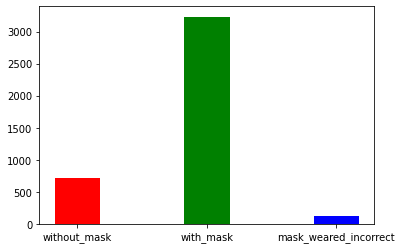

In [8]:
plt.bar(classes_dict.keys(), classes_dict.values(), 0.35, color = ['r','g','b'])

## Converting the data from Pascal VOC to YOLO format

In [74]:
classes_index = {}
index = 0
for cls in classes_dict.keys():
    classes_index[cls] = index
    index += 1
classes_index

{'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

In [91]:
for xml_file in xml_files:
    image_name = xml_file.replace('.xml','').replace('annotations/','')
    labels,box_cords,filename=decode_objects(xml_file)
    img_path=os.path.join('images',filename)
    img=cv2.imread(img_path,4)
    h,w,c = img.shape
    f = open(image_name + ".txt", "w")
    f.write("")
    f.close()
    for k in range(len(labels)):
        label_index=classes_index[labels[k]]
        x1,y1,x2,y2=box_cords[k]
        f = open(image_name + ".txt", "a")
        xc,yc = f"{(x1+x2)/2/w:.6f}", f"{(y1+y2)/2/h:.6f}"
        wn,hn = f"{(x2-x1)/w:.6f}", f"{(y2-y1)/h:.6f}"
        f.write(str(label_index) + ' ' + xc + ' ' + yc + ' ' + wn + ' ' + hn+'\n')
        f.close()

In [93]:
images_list =  glob.glob('images/*.png')
bb_list = glob.glob('images/*.txt')
len(images_list), len(bb_list)

(853, 853)

In [101]:
filename = bb_list[20]
with open(filename) as f:
    content = f.readlines()
content = [x.strip() for x in content]
lines = [line.split(' ') for line in content]

FileNotFoundError: [Errno 2] No such file or directory: 'images/maksssksksss616.txt'

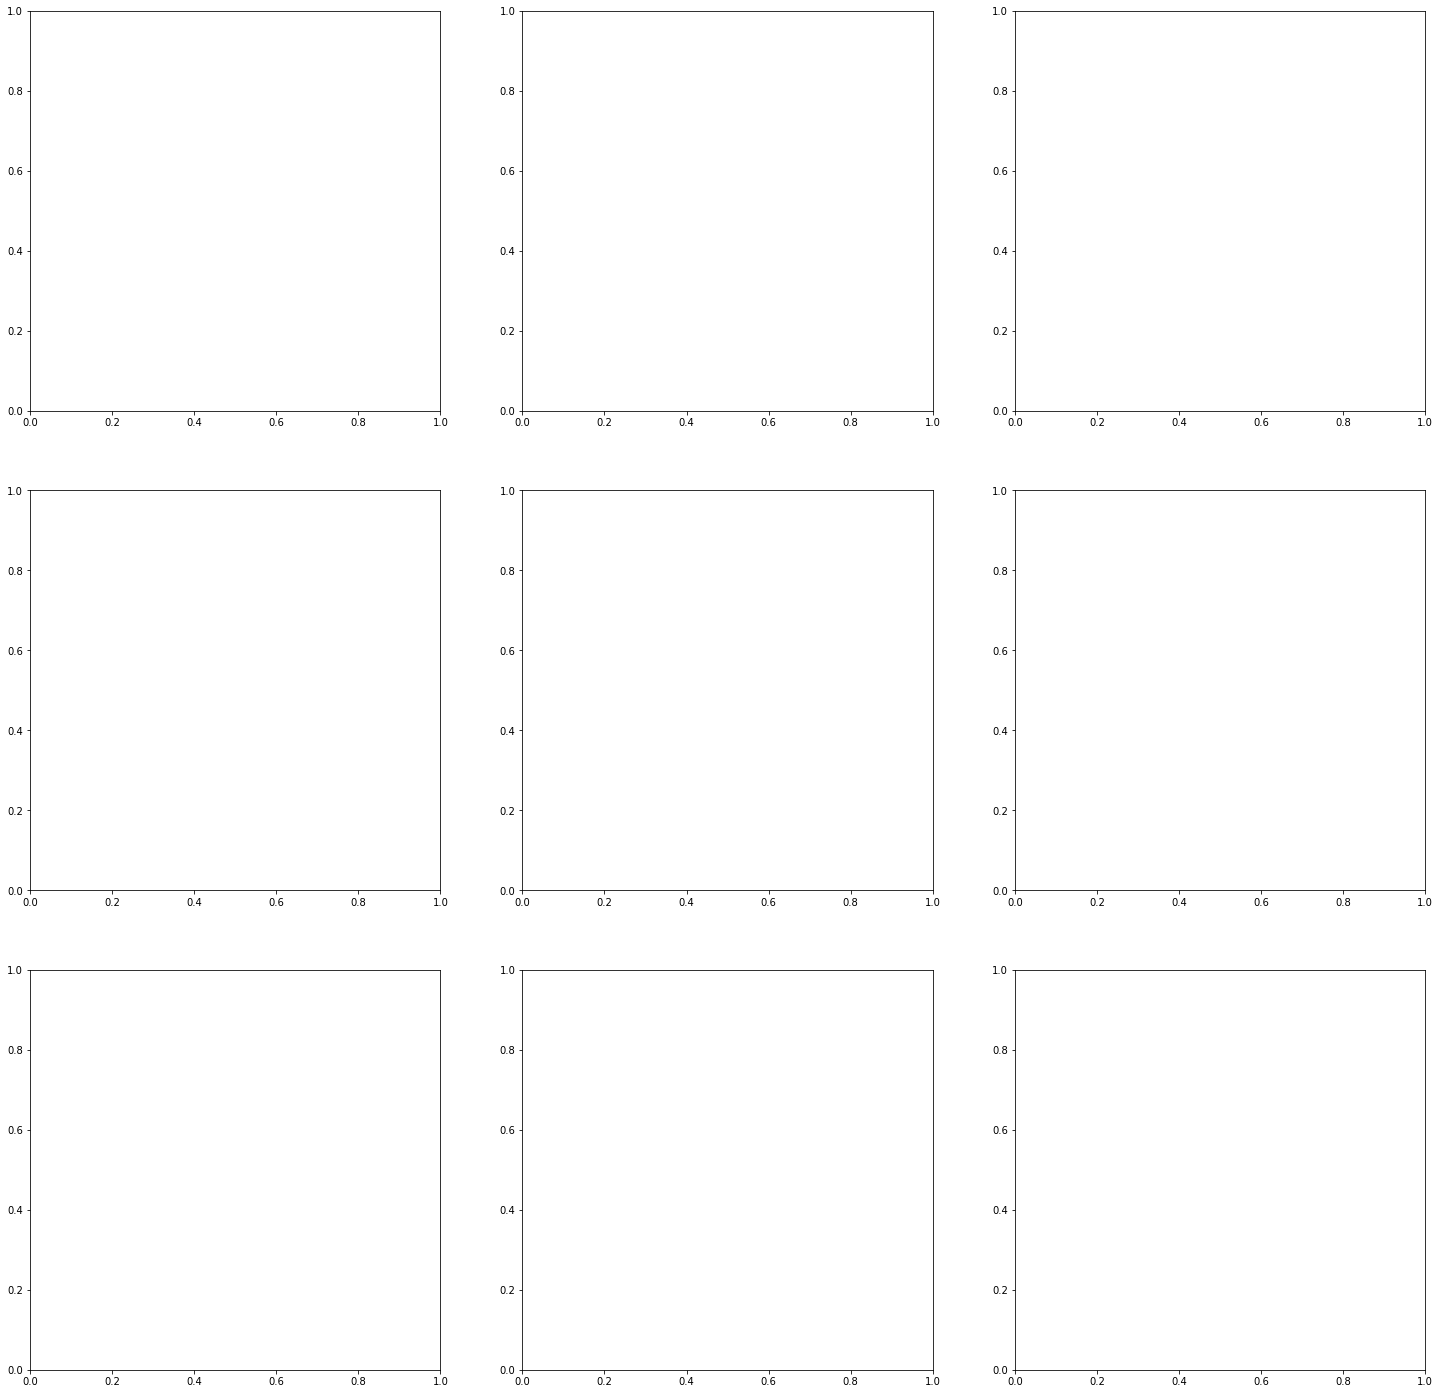

In [117]:
fig, ax = plt.subplots(3,3, figsize = (25,25))
for i in range(3):
    for j in range(3):
        random_img=np.random.randint(len(images_list))
        filename = bb_list[random_img]
        with open(filename) as f:
            content = f.readlines()
        content = [x.strip() for x in content] 
        lines = [line.split(' ') for line in content]
        img=cv2.imread(images_list[random_img])
        h,w,c = img.shape
        for line in lines:
            label_str=line[0]
            thickness = 2
            xc,yc,wn,hn = line[1:]
            xc,yc,wn,hn = float(xc),float(yc),float(wn),float(hn)
            x1,y1,x2,y2=(xc - wn/2)*w,  (yc - hn/2)*h, (xc + wn/2)*w,  (yc + hn/2)*h
            cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
            cv2.putText(img,label_str,(int(x1)-15,int(y2)-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,0,255), 2)
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))